In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score

# LOADING EXPLORING THE DATA

In [20]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

def explore_data(data):
    print("First 5 rows of the dataset:")
    print(data.head().T)
    print("\nStatistical summary:")
    print(data.describe())
    print("\nInformation about the dataset:")
    print(data.info())
    print("\nPercentage of missing values in each column:")
    print(data.isna().mean() * 100)

# VISUALIZING DE DATA

In [21]:
def plot_correlation_matrix(data):
    numericas = data.select_dtypes(exclude='object')
    matriz_correlacion = numericas.corr()
    plt.figure(figsize=(20, 10))
    sns.heatmap (matriz_correlacion, annot=True, fmt=".2f")
    plt.title('Mapa de Correlacion')
    plt.show()

In [22]:
def plot_histograms(data):
    data.hist(bins=15, figsize=(15, 15))
    plt.show()

In [23]:
def plot_feature_relationships(data, target):
    for column in data.columns[:-1]:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=column, y=target, data=data)
        plt.title(f'Relationship between total_UPDRS and {column}')
        plt.show()

# Preprocessing and feature engineering

In [24]:
def remove_correlated_columns(data):
    X = data.select_dtypes(include=['float64', 'int64']).drop(columns=['motor_UPDRS', 'total_UPDRS', 'sex'])
    y = data['total_UPDRS']
    correlated_cols = []
    for col in X:
        if 'total_UPDRS' in col or 'Jitter:RAP' in col or 'Jitter:PPQ5' in col or 'Jitter:DDP' in col or 'Shimmer(dB)' in col or 'Shimmer:APQ3' in col or 'Shimmer:APQ5' in col or 'Shimmer:APQ11' in col or 'Shimmer:DDA' in col:
            correlated_cols.append(col)

    # Crear un ColumnTransformer para eliminar las columnas correlacionadas
    preprocessing = ColumnTransformer(
        transformers=[
            ('drop_correlated_cols', 'drop', correlated_cols)
        ],
        remainder='passthrough'  # Mantener el resto de las variables
    )

    # Aplicar el ColumnTransformer para eliminar las columnas correlacionadas
    data_transformed = preprocessing.fit_transform(data)
    data = pd.DataFrame(data_transformed, columns=[col for col in data.columns if col not in correlated_cols])
    return data

In [25]:
def scale_features(data, target):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(data.drop(target, axis=1))
    data_scaled = pd.DataFrame(features_scaled, columns=data.columns[:-1])
    data_scaled[target] = data[target]
    return data_scaled

In [26]:
def pca_application(X_scaled):
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    print(f'Número de componentes: {pca.n_components_}')
    # Cálculo de la varianza acumulada
    varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

    # Determinación del número de componentes para explicar más del 90% de la varianza
    num_componentes_90 = np.where(varianza_acumulada >= 0.9)[0][0] + 1
    return num_componentes_90, varianza_acumulada


In [27]:
def plot_varianza(X_scaled):
    print("Aplicando PCA...")
    num_componentes_90, varianza_acumulada = pca_application(X_scaled)
    print("Graficando varianza acumulada...")
    plt.figure(figsize=(10, 6))
    plt.plot(varianza_acumulada, marker='o', linestyle='-', color='blue')
    plt.title('Varianza acumulada')
    plt.show()

    # Impresión de resultados
    print(f"Número mínimo: {num_componentes_90}")

# Splitting the dataset

In [28]:
def split_data(data, target, test_size=0.2, random_state=42):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Training the model

In [29]:
def train_model(X_train, y_train):
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    return model

# Evaluating the model

In [30]:
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return mae, r2

In [31]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae , r2 = eval_metrics(y_test, y_pred)
    print(f'Mean Absolute Error (Averaged XGBoost and Random Forest): {mae}')
    print(f'R2 Score (Averaged XGBoost and Random Forest): {r2}')

In [32]:
def plot_nocorrelated(data):
    numericas = data.select_dtypes(exclude='object')
    matriz_correlacion = numericas.corr()

    plt.figure(figsize=(20, 10))
    sns.heatmap (matriz_correlacion, annot=True, fmt=".2f")
    plt.title('Mapa de Correlacion')
    plt.show()

# Cross Validation

In [33]:
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv)
    print("Average Accuracy with CV:", np.mean(scores))

In [34]:
# Main function for running the pipeline
def main(filepath):
    data = load_data(filepath)
    explore_data(data)
    plot_histograms(data)
    plot_correlation_matrix(data)
    plot_feature_relationships(data, 'total_UPDRS')
    
    data_nonullsdf = remove_correlated_columns(data)
    data_scaled = scale_features(data_nonullsdf, 'total_UPDRS')
    plot_varianza(data_scaled)
    plot_nocorrelated(data_scaled)
    X_train, X_test, y_train, y_test = split_data(data_scaled, 'total_UPDRS')
    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    cross_validate_model(model, data_nonullsdf.drop('total_UPDRS', axis=1), data_nonullsdf['total_UPDRS'])

First 5 rows of the dataset:
                       0          1          2          3          4
subject#        1.000000   1.000000   1.000000   1.000000   1.000000
age            72.000000  72.000000  72.000000  72.000000  72.000000
sex             0.000000   0.000000   0.000000   0.000000   0.000000
test_time       5.643100  12.666000  19.681000  25.647000  33.642000
motor_UPDRS    28.199000  28.447000  28.695000  28.905000  29.187000
total_UPDRS    34.398000  34.894000  35.389000  35.810000  36.375000
Jitter(%)       0.006620   0.003000   0.004810   0.005280   0.003350
Jitter(Abs)     0.000034   0.000017   0.000025   0.000027   0.000020
Jitter:RAP      0.004010   0.001320   0.002050   0.001910   0.000930
Jitter:PPQ5     0.003170   0.001500   0.002080   0.002640   0.001300
Jitter:DDP      0.012040   0.003950   0.006160   0.005730   0.002780
Shimmer         0.025650   0.020240   0.016750   0.023090   0.017030
Shimmer(dB)     0.230000   0.179000   0.181000   0.327000   0.176000
Shimm

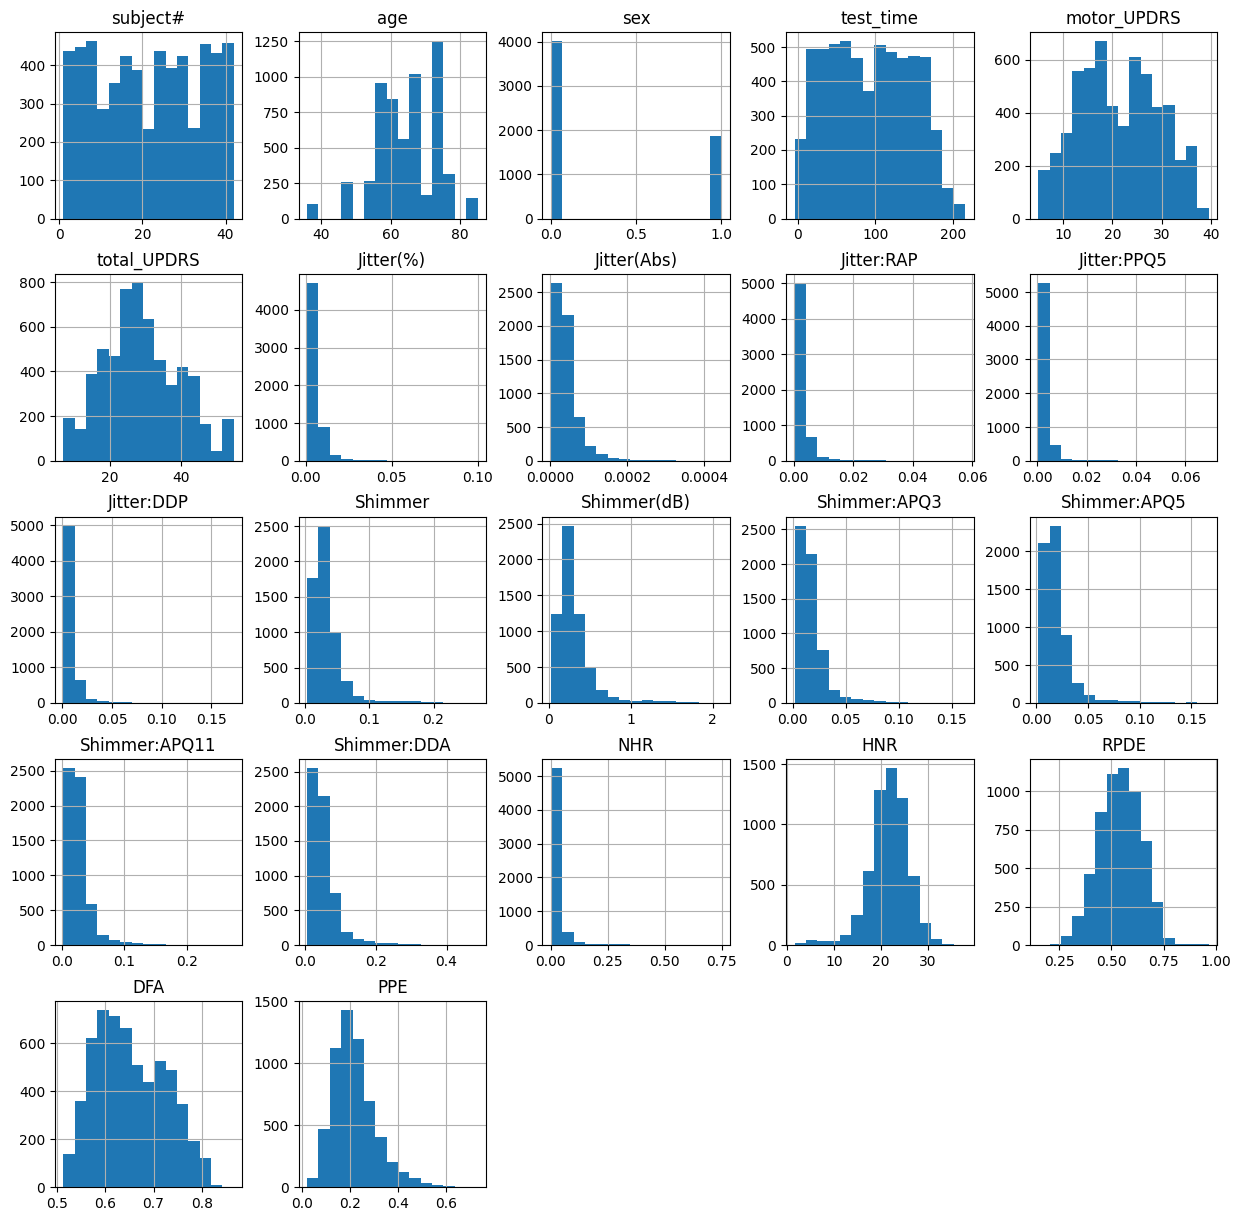

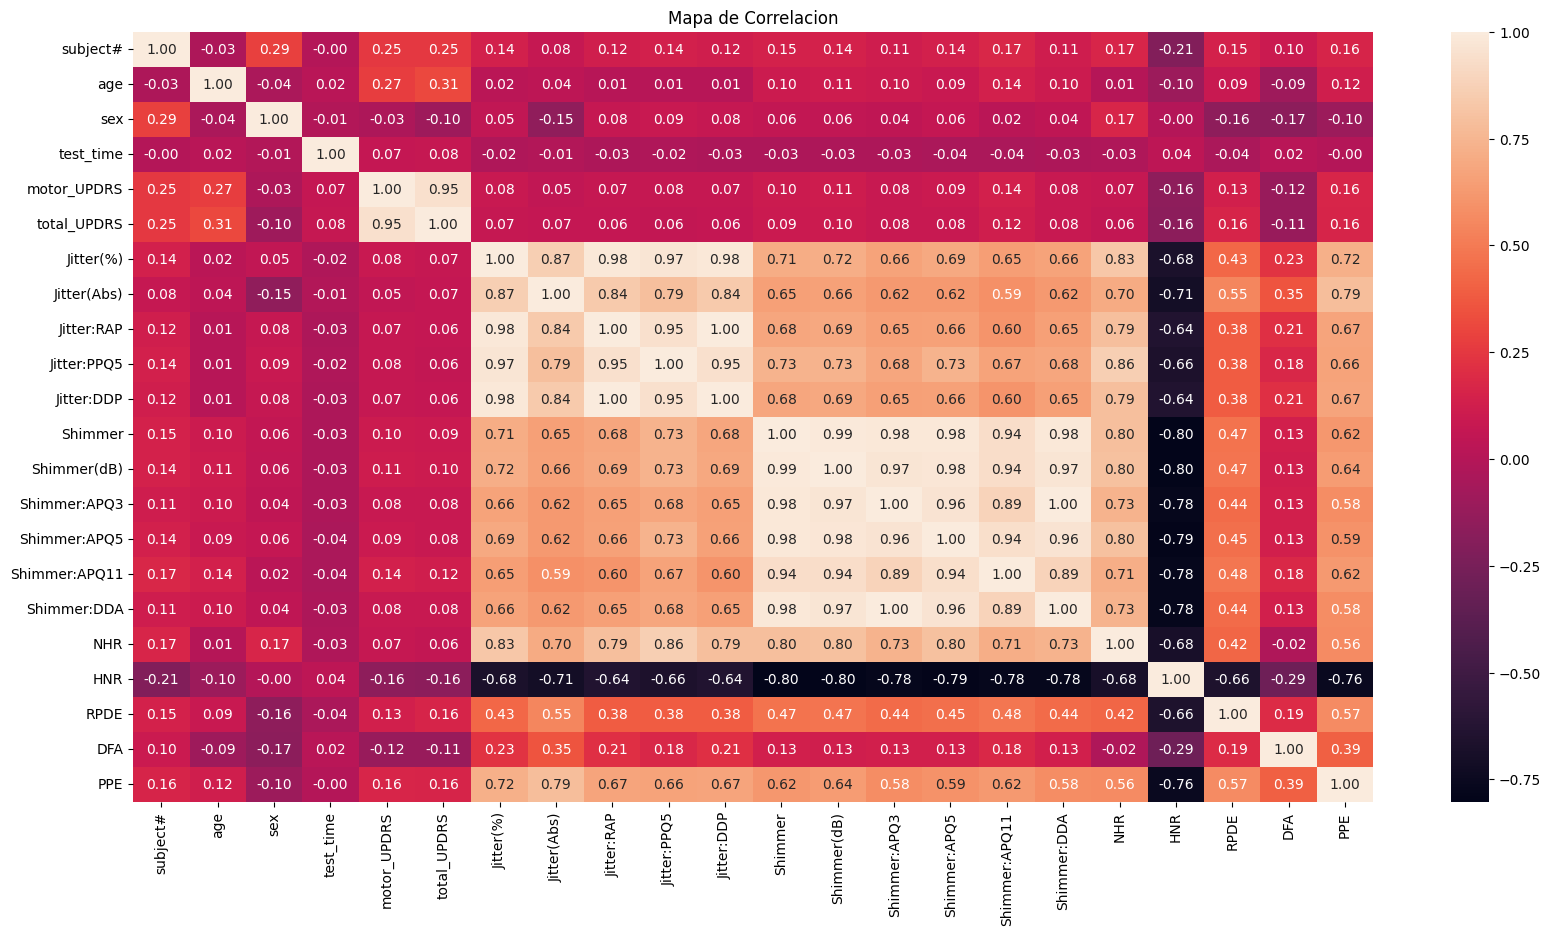

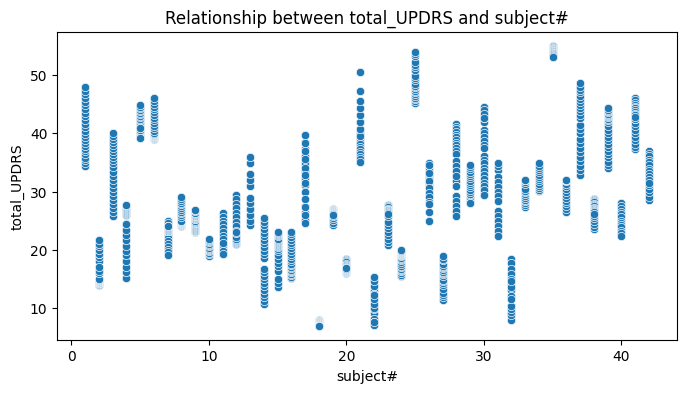

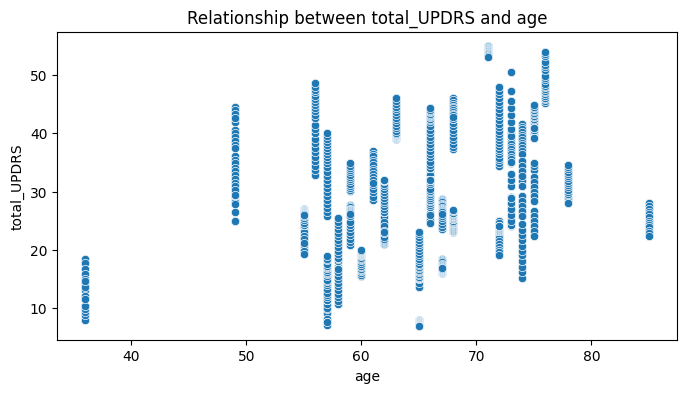

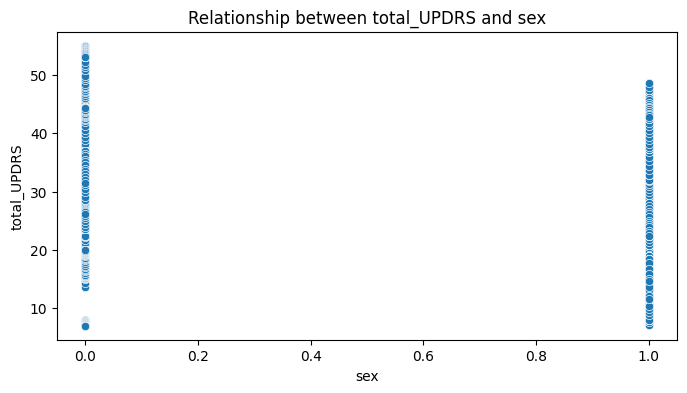

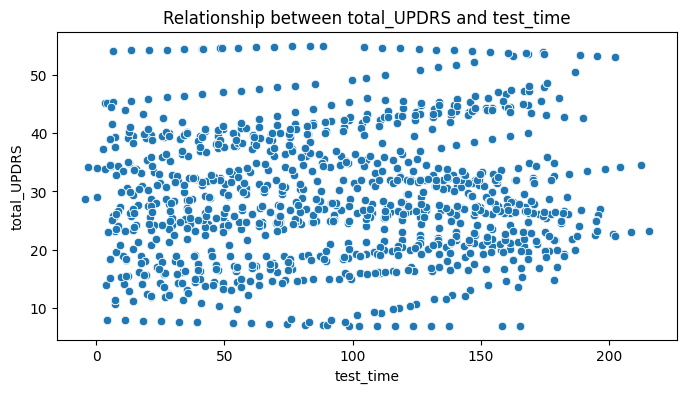

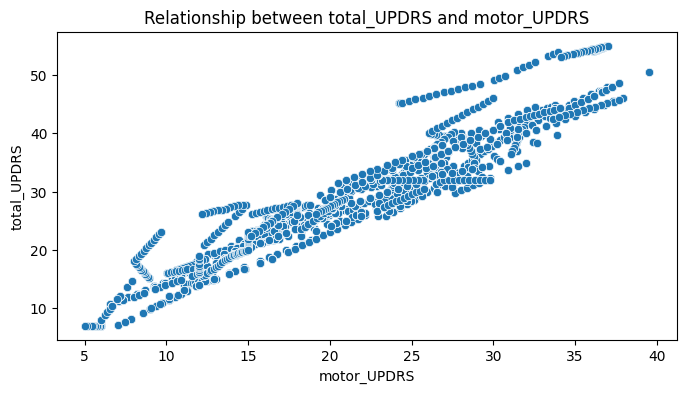

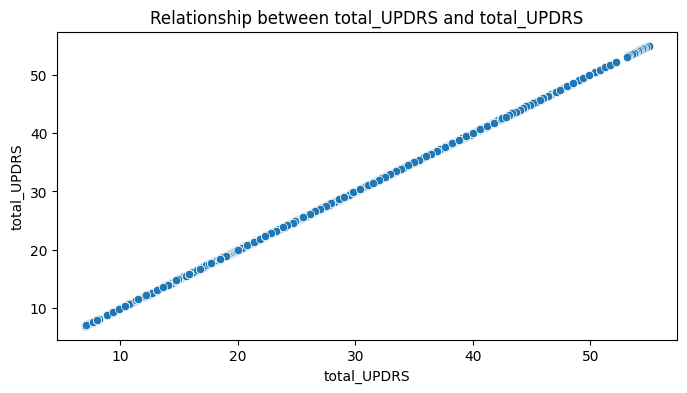

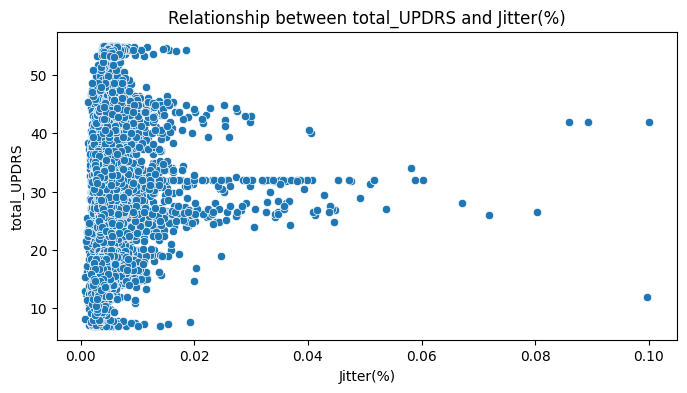

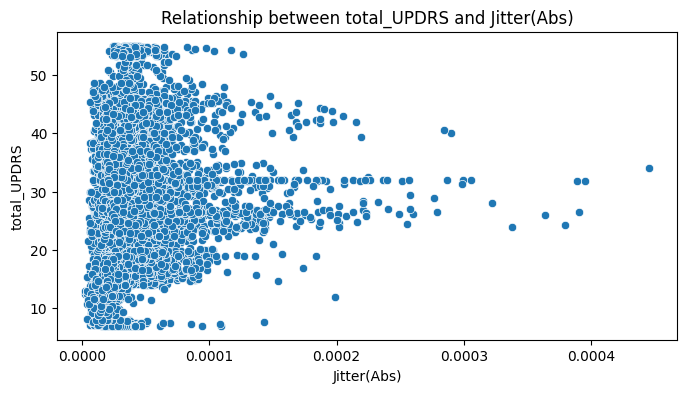

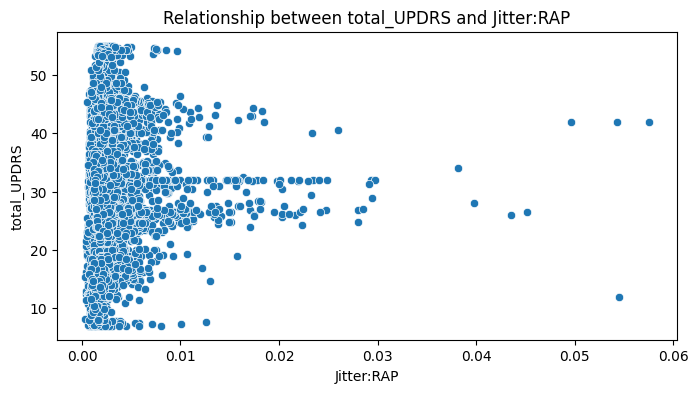

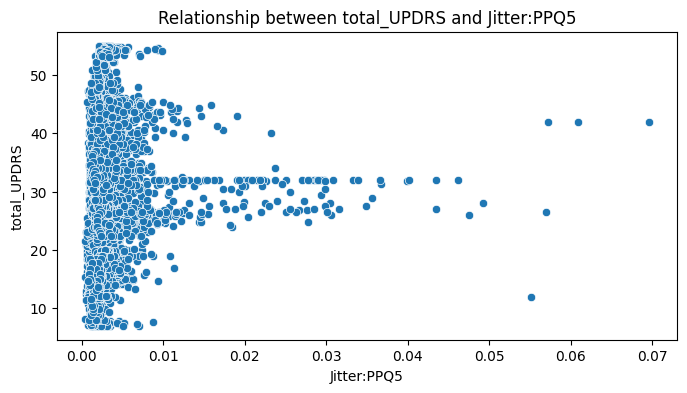

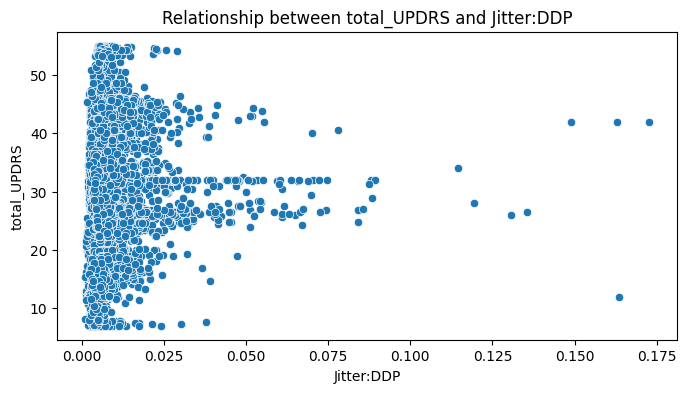

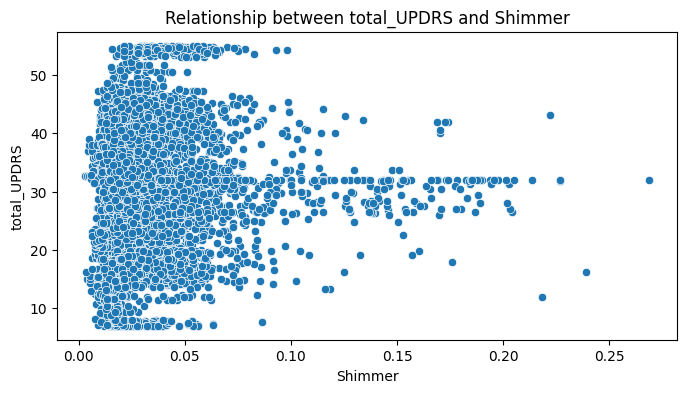

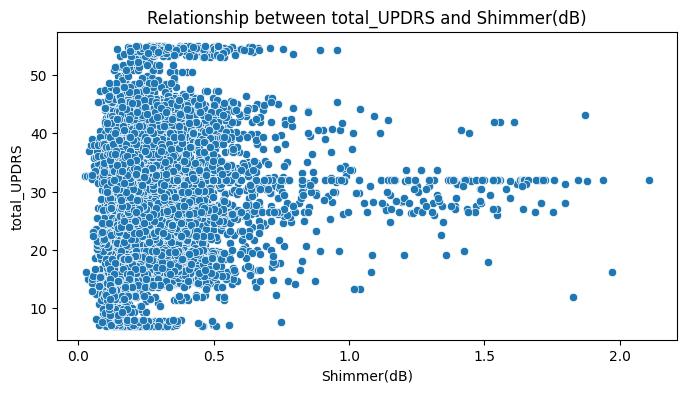

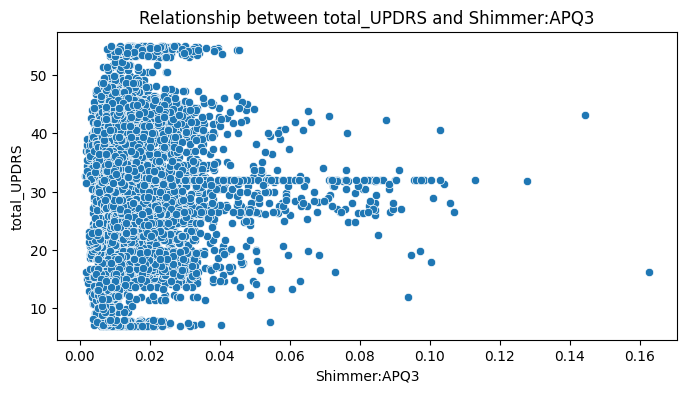

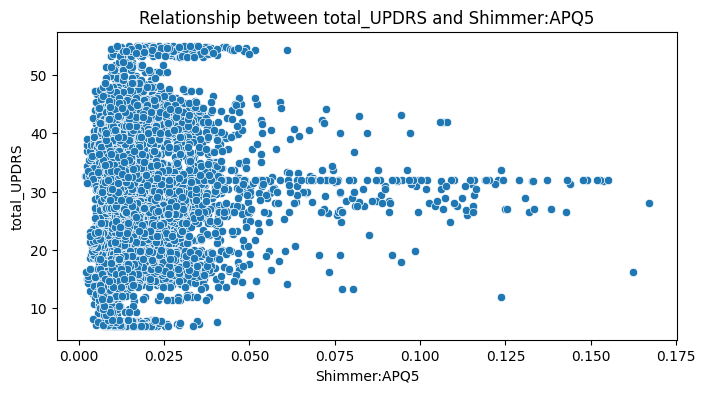

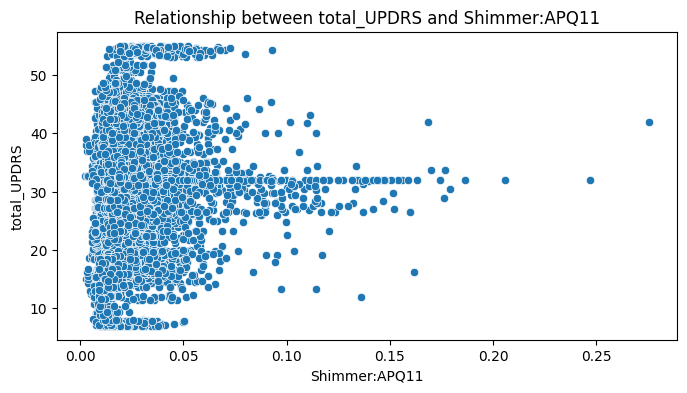

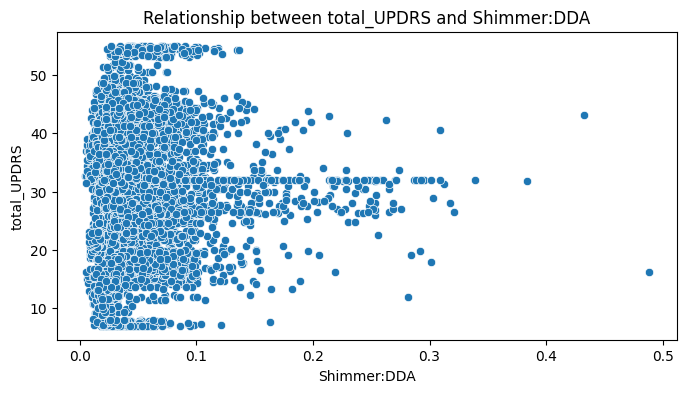

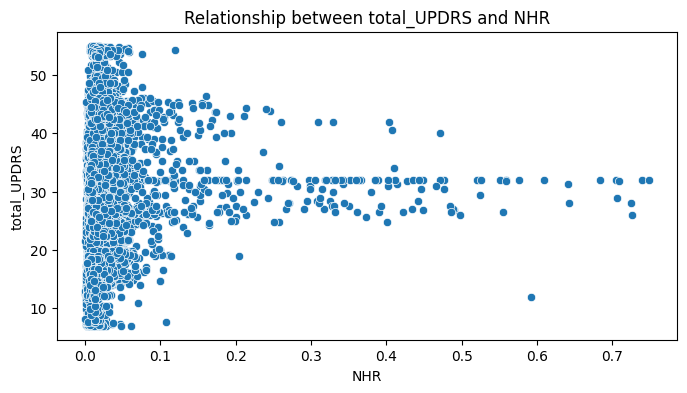

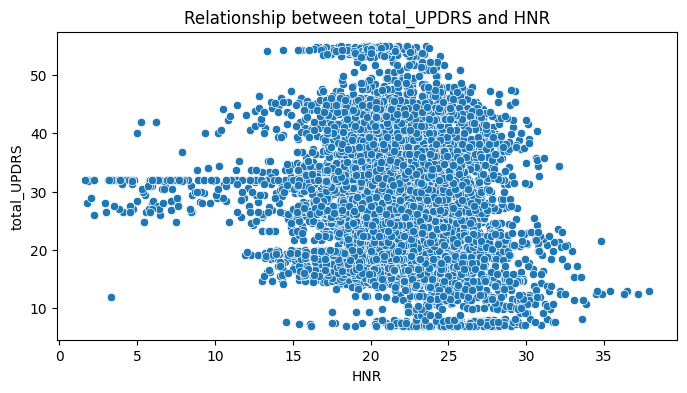

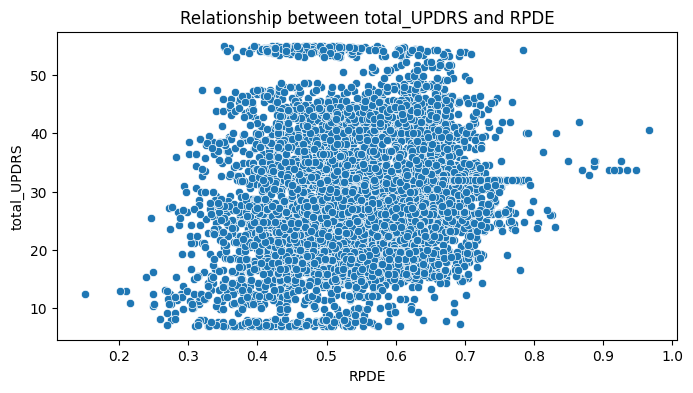

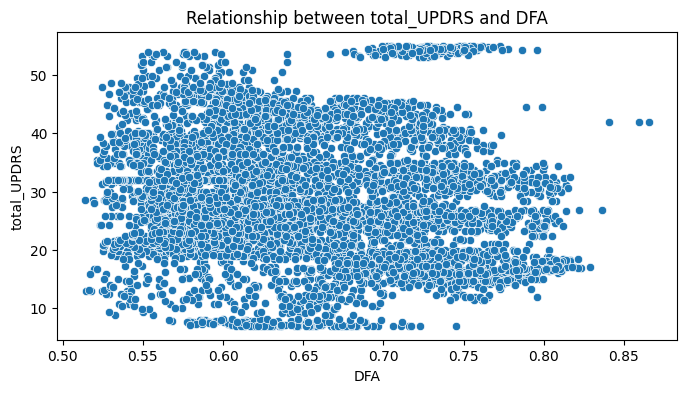

Aplicando PCA...
Número de componentes: 13
Graficando varianza acumulada...


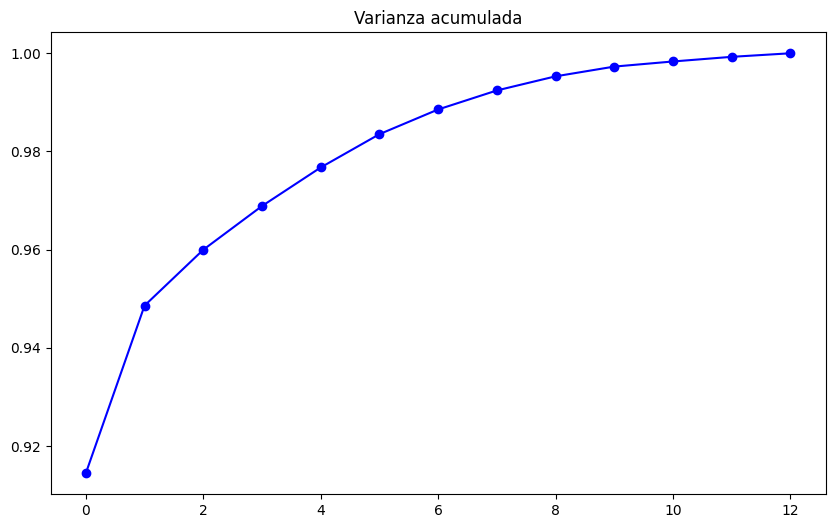

Número mínimo: 1


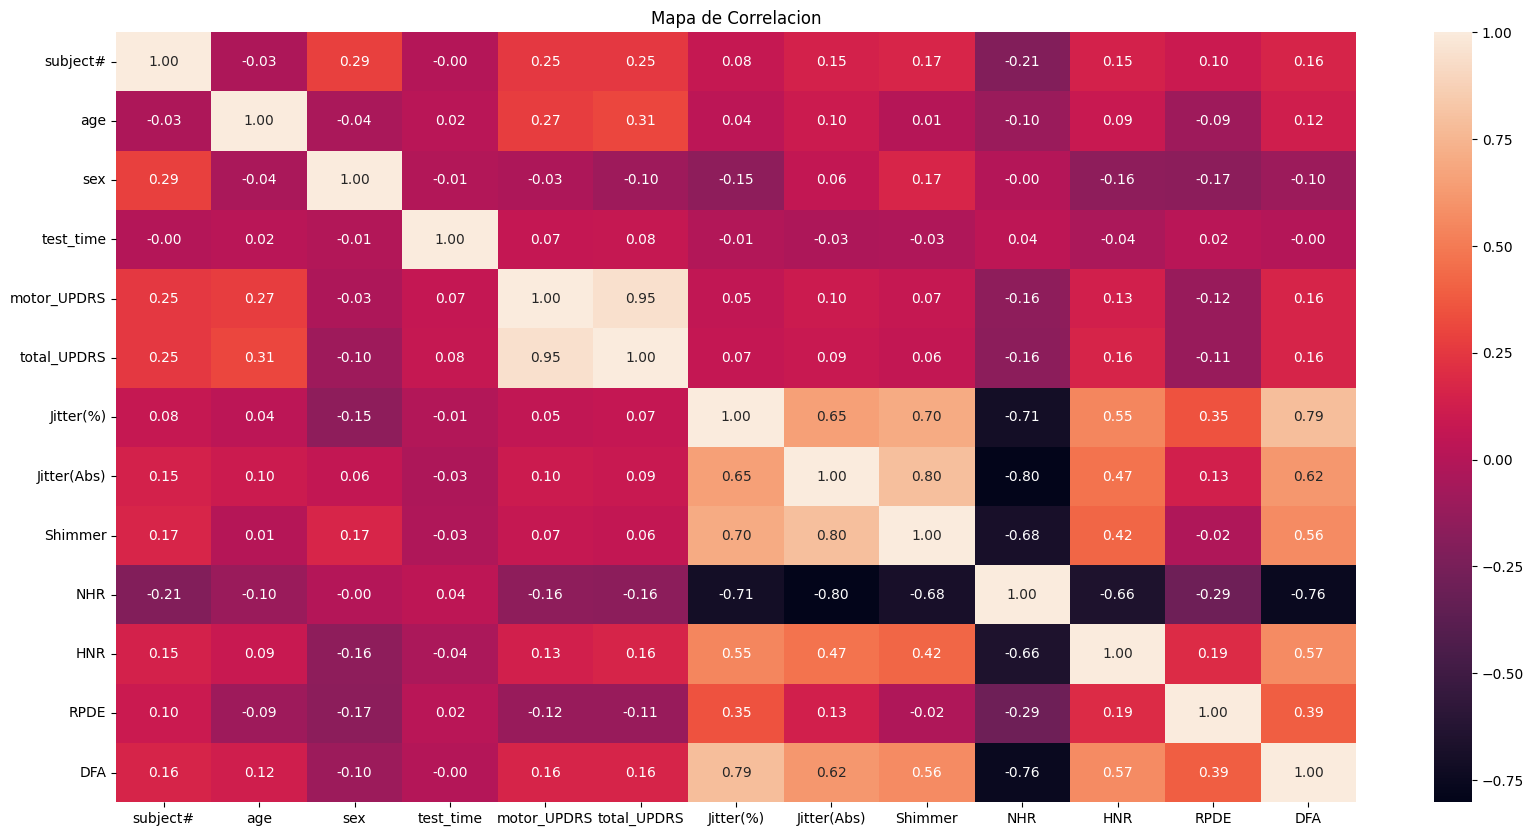

Mean Absolute Error (Averaged XGBoost and Random Forest): 0.9435882347306014
R2 Score (Averaged XGBoost and Random Forest): 0.9863527720736419
Average Accuracy with CV: 0.703958866457997


In [35]:
main(filepath=r'D:\DevOps\MLOpsPactices\Parkinson\parkinsons_updrs.data')